<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/baseline_keras_xception_car_class_v2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 
По ходу решения мы будем давать вам рекомендации, которые помогут улучшить качество модели. 


Удачи и Поехали!

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Aug 19 16:57:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    36W / 250W |  11819MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input"))
print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 25  # эпох на обучение
BATCH_SIZE           = 32 #64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 350 #224 # начнем с малого 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# DATA_PATH = '../input/'
# PATH = "../working/car/" # рабочая директория

DATA_PATH =  DIR + 'input/'
PATH = DIR + "working/car/" # рабочая директория
ver = '4_2'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,  exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
#train_df.head()

In [ ]:
#train_df.info()

In [ ]:
#train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [ ]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     #with zipfile.ZipFile("../input/"+data_zip,"r") as z:
#     with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:  
#         z.extractall(PATH)
        
# print(os.listdir(PATH))

In [ ]:
# print('Пример картинок (random sample)')
# plt.figure(figsize=(12,8))

# random_image = train_df.sample(n=9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
#     plt.subplot(3,3, index+1)
#     plt.imshow(im)
#     plt.title('Class: '+str(random_image_cat[index]))
#     plt.axis('off')
# plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
# image = PIL.Image.open(PATH+'/train/0/100380.jpg')
# imgplot = plt.imshow(image)
# plt.show()
# image.size

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Аугментация данных

In [ ]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

#test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

#test_sub_generator = test_datagen.flow_from_dataframe( 
test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
 #   K.set_session(s)
    tf.compat.v1.keras.backend.set_session(s)

s = reset_tf_session()

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
#base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

In [ ]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # x = Dropout(0.25)(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# # x = Dropout(0.25)(x)
# # x = Dense(512, activation='relu')(x)
# # x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# #x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
base_model.trainable = False

In [ ]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Сконфигурируем модель для категориальной классификации.
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=LR), metrics=["accuracy"])

#model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=LR, momentum=0.9), metrics=["accuracy"])

In [ ]:
#model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint(DIR + f'best_model/best_model{ver}.hdf5' , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

In [ ]:
# mode_train False - all layers frezee, True - all layers not frezee
def config_model(model, mode_train, l_r, ephochs, steps_per_epoch, validation_steps,   fine_tune_at = 0):
    base_model.trainable = mode_train
    if fine_tune_at > 0 :

# Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=l_r), metrics=["accuracy"])

    scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
    print("Accuracy before fit: %.2f%%" % (scores[1]*100))

    history =    model.fit(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = test_generator, 
        validation_steps = validation_steps,
        epochs = ephochs,
        callbacks = callbacks_list
       )
    
    # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
    model.save(DIR + f'working/model_last{ver}.hdf5')

    model.load_weights(DIR +f'best_model/best_model{ver}.hdf5')

    scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
    print("Accuracy after: %.2f%%" % (scores[1]*100))

    plot_history(history)

1/1 [==============================] - 0s 2ms/step - loss: 2.3190 - accuracy: 0.1250
Accuracy before fit: 12.50%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 1.7085 - accuracy: 0.4032
Epoch 00001: val_accuracy improved from -inf to 0.51911, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 469s 1s/step - loss: 1.7085 - accuracy: 0.4032 - val_loss: 1.2536 - val_accuracy: 0.5191
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 1.3284 - accuracy: 0.5110
Epoch 00002: val_accuracy improved from 0.51911 to 0.55603, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 461s 1s/step - loss: 1.3284 - accuracy: 0.5110 - val_loss: 1.2048 - val_accuracy: 0.5560
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.5587
Ep

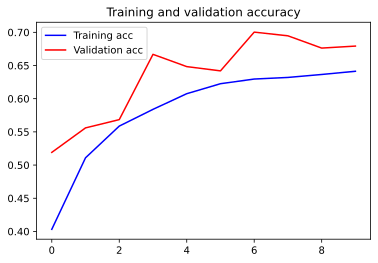

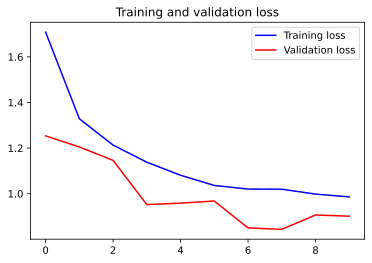

In [ ]:
# train only head
config_model(model, False, l_r = 0.001, ephochs = 10, steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = 0)

In [ ]:
# Let's take a look to see how many layers are in the base model
base_layers = len(base_model.layers)
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


1/1 [==============================] - 0s 4ms/step - loss: 1.0428 - accuracy: 0.6562
Accuracy before fit: 65.62%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.8037
Epoch 00001: val_accuracy improved from 0.70030 to 0.89910, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 464s 1s/step - loss: 0.5498 - accuracy: 0.8037 - val_loss: 0.2793 - val_accuracy: 0.8991
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9135
Epoch 00002: val_accuracy improved from 0.89910 to 0.93302, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 472s 1s/step - loss: 0.2565 - accuracy: 0.9135 - val_loss: 0.1914 - val_accuracy: 0.9330
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9449

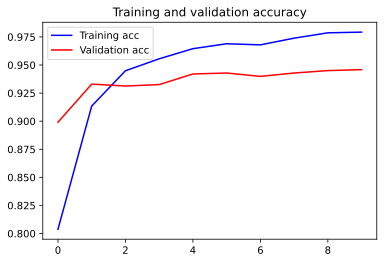

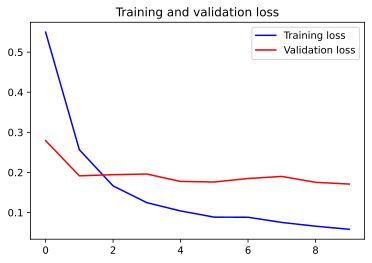

In [ ]:
# step 1 
config_model(model, True, l_r = 0.0001, ephochs = 10, steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = base_layers//2)

1/1 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.9062
Accuracy before fit: 90.62%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9809
Epoch 00001: val_accuracy improved from 0.94590 to 0.94805, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 463s 1s/step - loss: 0.0562 - accuracy: 0.9809 - val_loss: 0.1640 - val_accuracy: 0.9480
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9870
Epoch 00002: val_accuracy improved from 0.94805 to 0.95148, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 462s 1s/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.1677 - val_accuracy: 0.9515
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9884

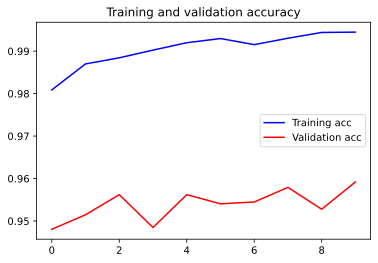

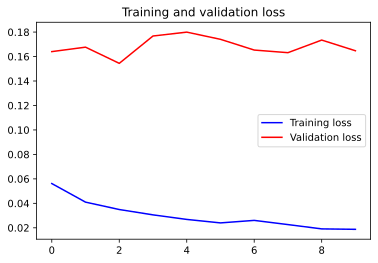

In [ ]:
# step 2 
config_model(model, True, l_r = 0.00001, ephochs = 10, steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = base_layers//4)

1/1 [==============================] - 0s 3ms/step - loss: 0.0818 - accuracy: 0.9688
Accuracy before fit: 96.88%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9955
Epoch 00001: val_accuracy did not improve from 0.95921
414/414 [==============================] - 456s 1s/step - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.1851 - val_accuracy: 0.9519
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9951
Epoch 00002: val_accuracy did not improve from 0.95921
414/414 [==============================] - 470s 1s/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.1801 - val_accuracy: 0.9558
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9955
Epoch 00003: val_accuracy did not improve from 0.95921
414/414 [==============================] - 466s 1s/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.1832 - val_accuracy: 0.9549
Epoch 4/10
414/414 [==================

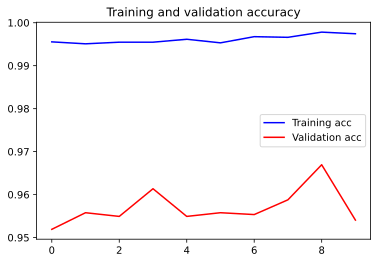

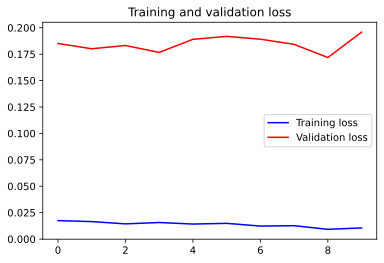

In [ ]:
# step 3 
config_model(model, True, l_r = 0.00001, ephochs = 10, steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = base_layers//8)

In [ ]:
# step 4 
config_model(model, True, l_r = 0.00001, ephochs = 20 , steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = 0)

1/1 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.9062
Accuracy before fit: 90.62%
Epoch 1/20
414/414 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9976
Epoch 00001: val_accuracy did not improve from 0.96694
414/414 [==============================] - 490s 1s/step - loss: 0.0101 - accuracy: 0.9976 - val_loss: 0.1671 - val_accuracy: 0.9644
Epoch 2/20
414/414 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961
Epoch 00002: val_accuracy did not improve from 0.96694
414/414 [==============================] - 484s 1s/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.1909 - val_accuracy: 0.9575
Epoch 3/20
414/414 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9968
Epoch 00003: val_accuracy did not improve from 0.96694
414/414 [==============================] - 482s 1s/step - loss: 0.0133 - accuracy: 0.9968 - val_loss: 0.1917 - val_accuracy: 0.9588
Epoch 4/20
414/414 [==================

73/73 [==============================] - 68s 930ms/step - loss: 0.1816 - accuracy: 0.9579
Accuracy before fit: 95.79%
Epoch 1/20
414/414 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9957
Epoch 00001: val_accuracy improved from -inf to 0.96007, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 481s 1s/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.1824 - val_accuracy: 0.9601
Epoch 2/20
414/414 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9963
Epoch 00002: val_accuracy improved from 0.96007 to 0.96093, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model4_1.hdf5
414/414 [==============================] - 485s 1s/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.1689 - val_accuracy: 0.9609
Epoch 3/20
414/414 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.99

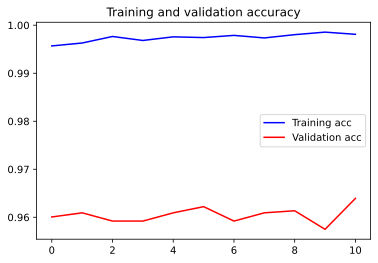

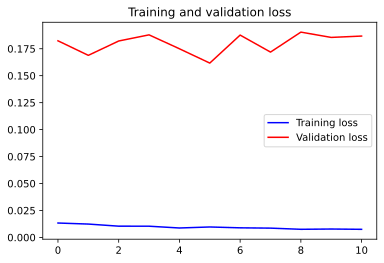

In [ ]:

# model.load_weights(DIR +f'best_model/best_model4_1.hdf5')

# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy after: %.2f%%" % (scores[1]*100))

# step 4 
config_model(model, True, l_r = 0.000006, ephochs = 20 , steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = 0)

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

6675

In [ ]:
# test_sub_generator.reset()
# predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
# predictions = np.argmax(predictions, axis=-1) #multiple categories
# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

In [ ]:
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
#    preds = model.predict_generator(train_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.
209/209 [==============================] - 1798s 9s/step


 10%|█         | 1/10 [30:09<4:31:21, 1809.03s/it]

209/209 [==============================] - 193s 926ms/step


 20%|██        | 2/10 [33:24<2:56:39, 1324.93s/it]

209/209 [==============================] - 194s 929ms/step


 30%|███       | 3/10 [36:40<1:55:03, 986.28s/it] 

209/209 [==============================] - 191s 912ms/step


 40%|████      | 4/10 [39:53<1:14:48, 748.17s/it]

209/209 [==============================] - 194s 929ms/step


 50%|█████     | 5/10 [43:09<48:32, 582.51s/it]  

209/209 [==============================] - 192s 920ms/step


 60%|██████    | 6/10 [46:23<31:04, 466.01s/it]

209/209 [==============================] - 197s 941ms/step


 70%|███████   | 7/10 [49:41<19:17, 385.78s/it]

209/209 [==============================] - 194s 930ms/step


 80%|████████  | 8/10 [52:58<10:57, 328.91s/it]

209/209 [==============================] - 197s 944ms/step


 90%|█████████ | 9/10 [56:17<04:49, 289.98s/it]

209/209 [==============================] - 203s 970ms/step


100%|██████████| 10/10 [59:41<00:00, 358.17s/it]


In [ ]:
# l_predictions[0].any()==l_predictions[2].any()
# l_predictions[0][:10]== l_predictions[1][:10]

In [ ]:
# l_predictions[0][3], '/n',l_predictions[1][3],'/n', l_predictions[2][3],'/n',(l_predictions[0][3]+l_predictions[1][3]+ l_predictions[2][3])/3

In [ ]:
#pred[3]

In [ ]:
#l_predictions[1][:10]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [ ]:
#tmp_y = pd.concat([submission['Category']])

In [ ]:
#filenames_with_dir

In [ ]:
# Clean PATH
# import shutil
# shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!